**K-Nearest Neighbors (KNN) Regressor Implementation**

The K-Nearest Neighbors (KNN) Regressor is a simple yet powerful non-parametric machine learning algorithm used for regression tasks. Instead of learning explicit model parameters, KNN makes predictions based on the similarity between data points. For any new observation, the algorithm identifies the ‘k’ closest data points (neighbors) in the training set—using distance metrics such as Euclidean or Manhattan distance—and predicts the target value as the average of those neighbors’ outputs.

KNN is particularly useful when the relationship between features and the target variable is nonlinear or complex, as it makes minimal assumptions about the underlying data distribution. It is intuitive, easy to implement, and effective for smaller datasets. However, it can become computationally expensive with large datasets and may be sensitive to irrelevant features or feature scaling.

Despite these limitations, KNN performs well in various domains such as housing price prediction, recommendation systems, and environmental modeling, where local patterns and neighborhood relationships significantly influence outcomes.

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib, warnings
warnings.filterwarnings("ignore")

from sklearn import __version__ as sklearn_version
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("scikit-learn version:", sklearn_version)
sns.set(style="whitegrid", context="notebook")


scikit-learn version: 1.6.1


In [2]:
#  Load California Housing dataset and preview
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing(as_frame=True)
df = data.frame
# identify target column (last column in the frame)
target_col = df.columns[-1]
# features and target
X = df.drop(columns=[target_col])
y = df[target_col]
print("First 10 rows of dataset:")
display(df.head(10))
print("\nColumns:", list(df.columns))
print("Dataset shape:", df.shape)


First 10 rows of dataset:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,2.992
7,3.1200,52.0,4.797527,1.061824,1157.0,1.788253,37.84,-122.25,2.414
8,2.0804,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26,2.267
9,3.6912,52.0,4.970588,0.990196,1551.0,2.172269,37.84,-122.25,2.611



Columns: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'MedHouseVal']
Dataset shape: (20640, 9)


In [3]:
#  Info and summary stats
print(" DataFrame info:")
print(df.info())

 DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB
None


In [4]:
print("\n Summary statistics:")
display(df.describe())


 Summary statistics:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


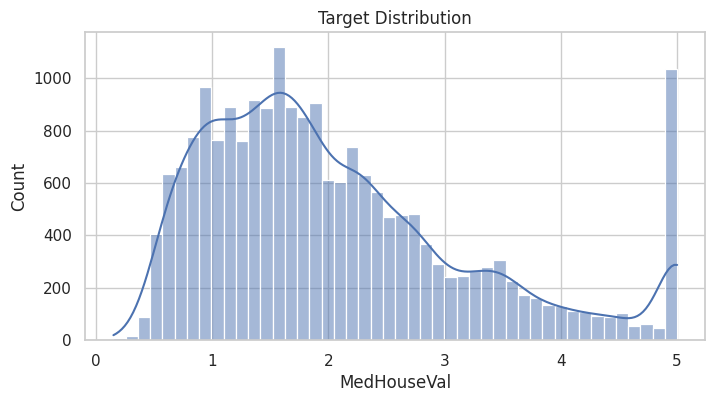

In [5]:
# target distribution
plt.figure(figsize=(8,4))
sns.histplot(y, kde=True)
plt.title("Target Distribution")
plt.xlabel(target_col)
plt.show()

Top correlations with target:
 MedHouseVal    1.000000
MedInc         0.688075
AveRooms       0.151948
Latitude       0.144160
HouseAge       0.105623
AveBedrms      0.046701
Longitude      0.045967
Population     0.024650
AveOccup       0.023737
Name: MedHouseVal, dtype: float64


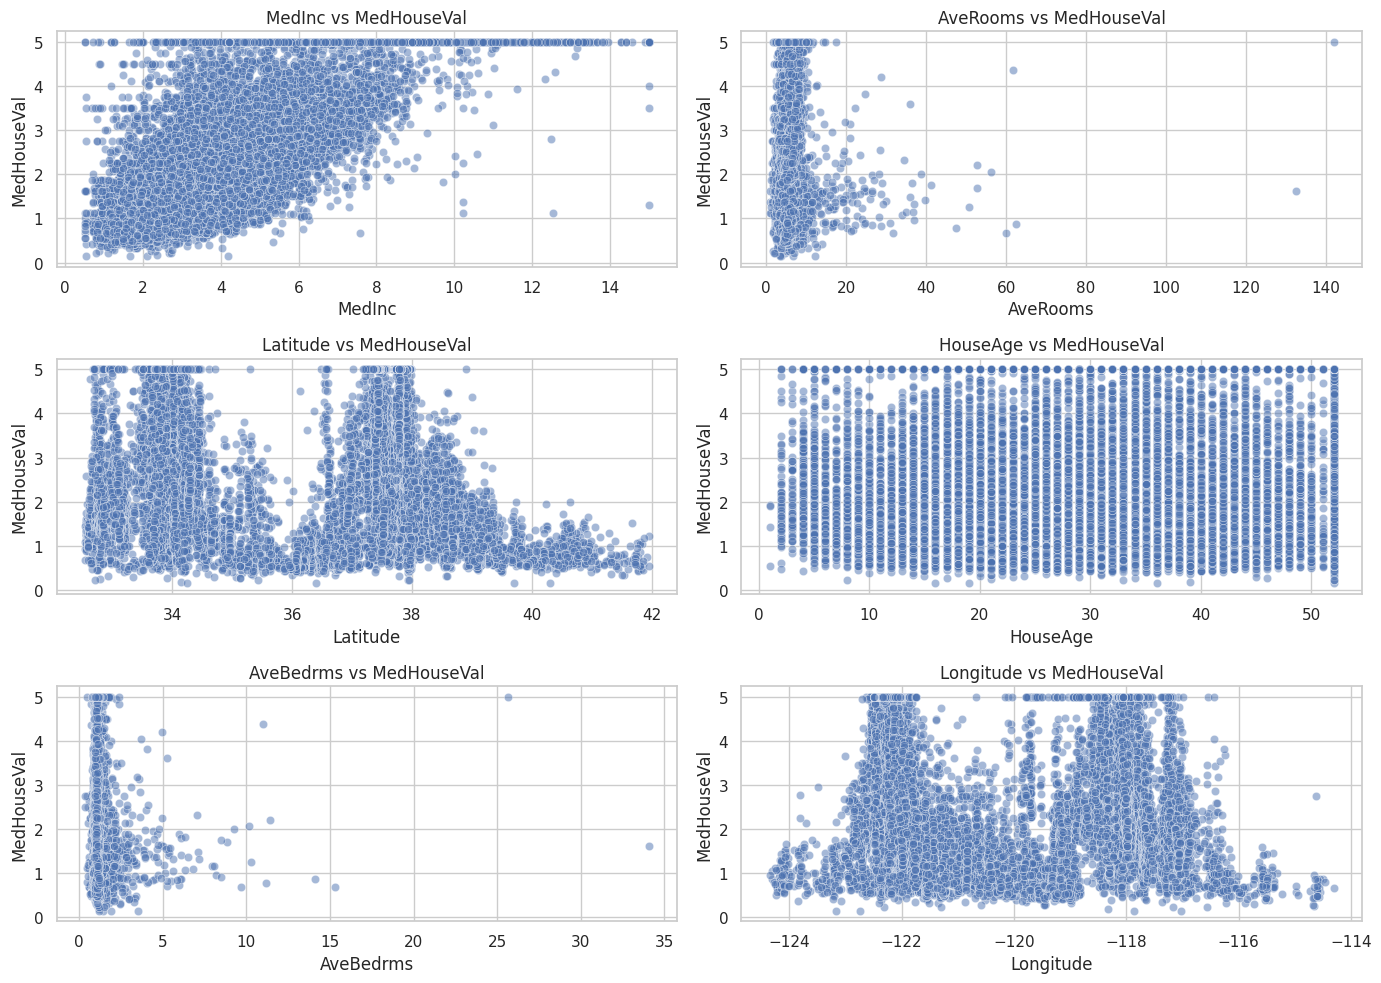

In [6]:
corr = df.corr()[target_col].abs().sort_values(ascending=False)
print("Top correlations with target:\n", corr.head(10))

top_feats = corr.index[1:7]  # top 6 features (exclude target itself)
plt.figure(figsize=(14,10))
for i, col in enumerate(top_feats, 1):
    plt.subplot(3, 2, i)
    sns.scatterplot(x=df[col], y=df[target_col], alpha=0.5)
    plt.title(f"{col} vs {target_col}")
    plt.xlabel(col)
    plt.ylabel(target_col)
plt.tight_layout()
plt.show()

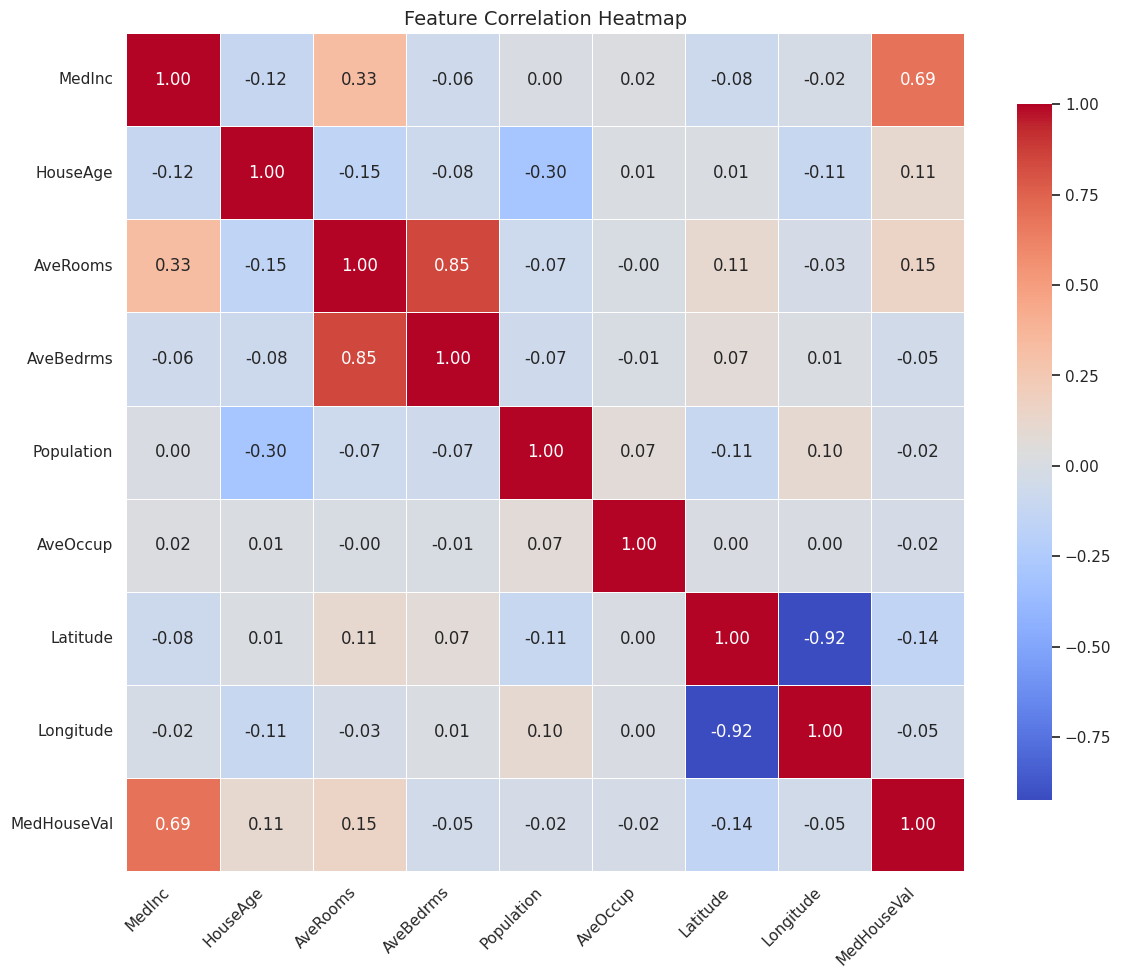

In [7]:
plt.figure(figsize=(12,10))
corr_matrix = df.corr()
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    square=True
)
plt.title("Feature Correlation Heatmap", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [8]:
#  Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (16512, 8)
Test shape: (4128, 8)


In [10]:

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor())
])

# Train baseline KNN
pipe.fit(X_train, y_train)

# Predict on test
y_pred = pipe.predict(X_test)

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Baseline KNN Performance:")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

Baseline KNN Performance:
MAE:  0.4462
RMSE: 0.6576
R²:   0.6700


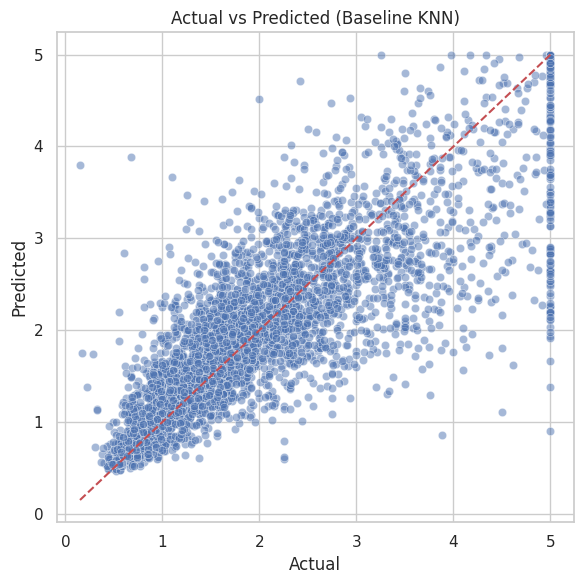

In [12]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted (Baseline KNN)")
plt.tight_layout()
plt.show()

In [13]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'knn__n_neighbors': list(range(1, 31)),
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]  # 1=Manhattan, 2=Euclidean
}

search = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    n_iter=10,
    scoring='neg_mean_squared_error',  # use neg MSE (safe across sklearn versions)
    cv=3,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1
)

search.fit(X_train, y_train)
print("Best params:", search.best_params_)
print("Best CV (neg MSE):", search.best_score_)
best_pipe = search.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params: {'knn__weights': 'distance', 'knn__p': 1, 'knn__n_neighbors': 19}
Best CV (neg MSE): -0.37099539845222346


In [14]:
y_pred_best = best_pipe.predict(X_test)

mae_best = mean_absolute_error(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best = r2_score(y_test, y_pred_best)

print("Tuned KNN Performance:")
print(f"MAE:  {mae_best:.4f}")
print(f"RMSE: {rmse_best:.4f}")
print(f"R²:   {r2_best:.4f}")

Tuned KNN Performance:
MAE:  0.4111
RMSE: 0.6079
R²:   0.7180


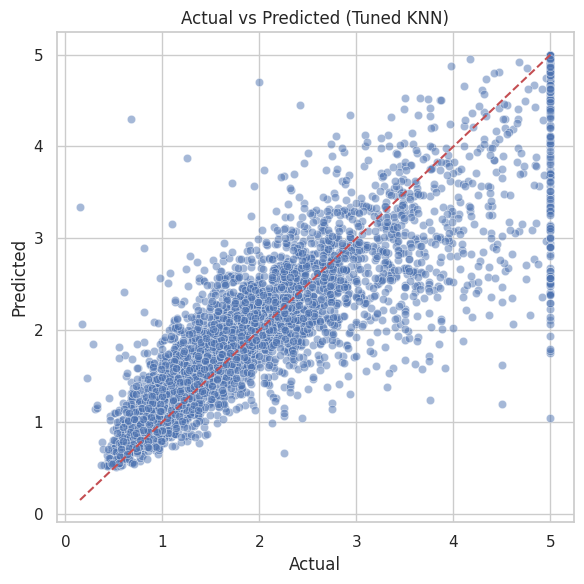

In [15]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_best, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted (Tuned KNN)")
plt.tight_layout()
plt.show()

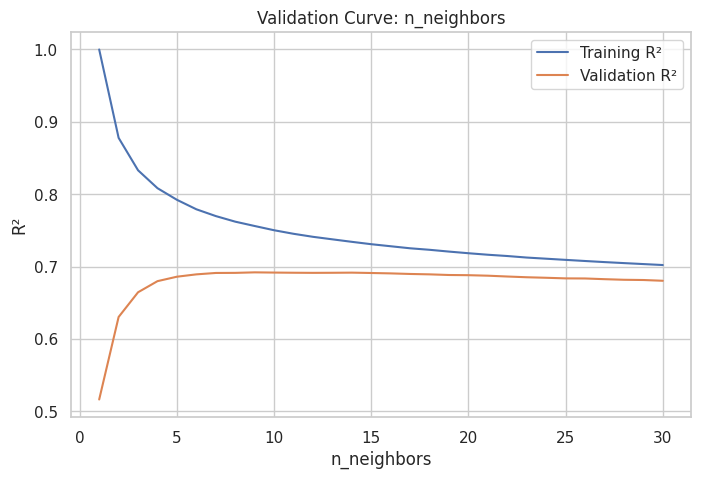

In [17]:
#  Validation curve for n_neighbors (R²)
from sklearn.model_selection import validation_curve
param_range = list(range(1, 31))
train_scores, test_scores = validation_curve(
    pipe, X_train, y_train,
    param_name='knn__n_neighbors',
    param_range=param_range,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.figure(figsize=(8,5))
plt.plot(param_range, train_mean, label='Training R²')
plt.plot(param_range, test_mean, label='Validation R²')
plt.xlabel("n_neighbors")
plt.ylabel("R²")
plt.title("Validation Curve: n_neighbors")
plt.legend()
plt.grid(True)
plt.show()


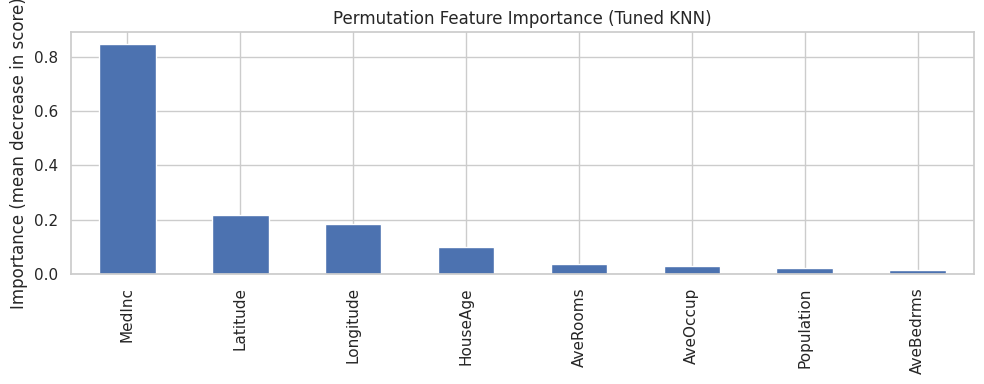

Top features:
 MedInc        0.846757
Latitude      0.216149
Longitude     0.182719
HouseAge      0.099318
AveRooms      0.037830
AveOccup      0.030921
Population    0.022615
AveBedrms     0.013662
dtype: float64


In [18]:
#  Permutation importance
from sklearn.inspection import permutation_importance

result = permutation_importance(best_pipe, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1)
importances = pd.Series(result.importances_mean, index=X.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,4))
importances.plot(kind='bar')
plt.title("Permutation Feature Importance (Tuned KNN)")
plt.ylabel("Importance (mean decrease in score)")
plt.tight_layout()
plt.show()

print("Top features:\n", importances.head(10))


In [19]:
# Save model
joblib.dump(best_pipe, '/content/knn_pipeline.joblib')
print("Saved tuned KNN pipeline to /content/knn_pipeline.joblib")


Saved tuned KNN pipeline to /content/knn_pipeline.joblib
